# Load Library

In [1]:
#load packages
import os
import cv2
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import confusion_matrix

#custom library
dir_main = os.getcwd()
dir_model = str(Path(dir_main).parent)
sys.path.append(dir_model)
from CT_2D_unet_lib.library import *
from CT_2D_unet_lib.model import *

#set directory
dir_CT_2D_dataset = dir_model + '/CT_2D_unet_dataset'
dir_CT_2D_dataset_test = dir_CT_2D_dataset + '/test_result'
dir_Data_Train = str(Path(dir_main).parent.parent.parent) + '/Data/Train/'
ckpt_dir = os.path.join(dir_main, "checkpoint")
history_dir = os.path.join(dir_main, "history")

# Load Dataset

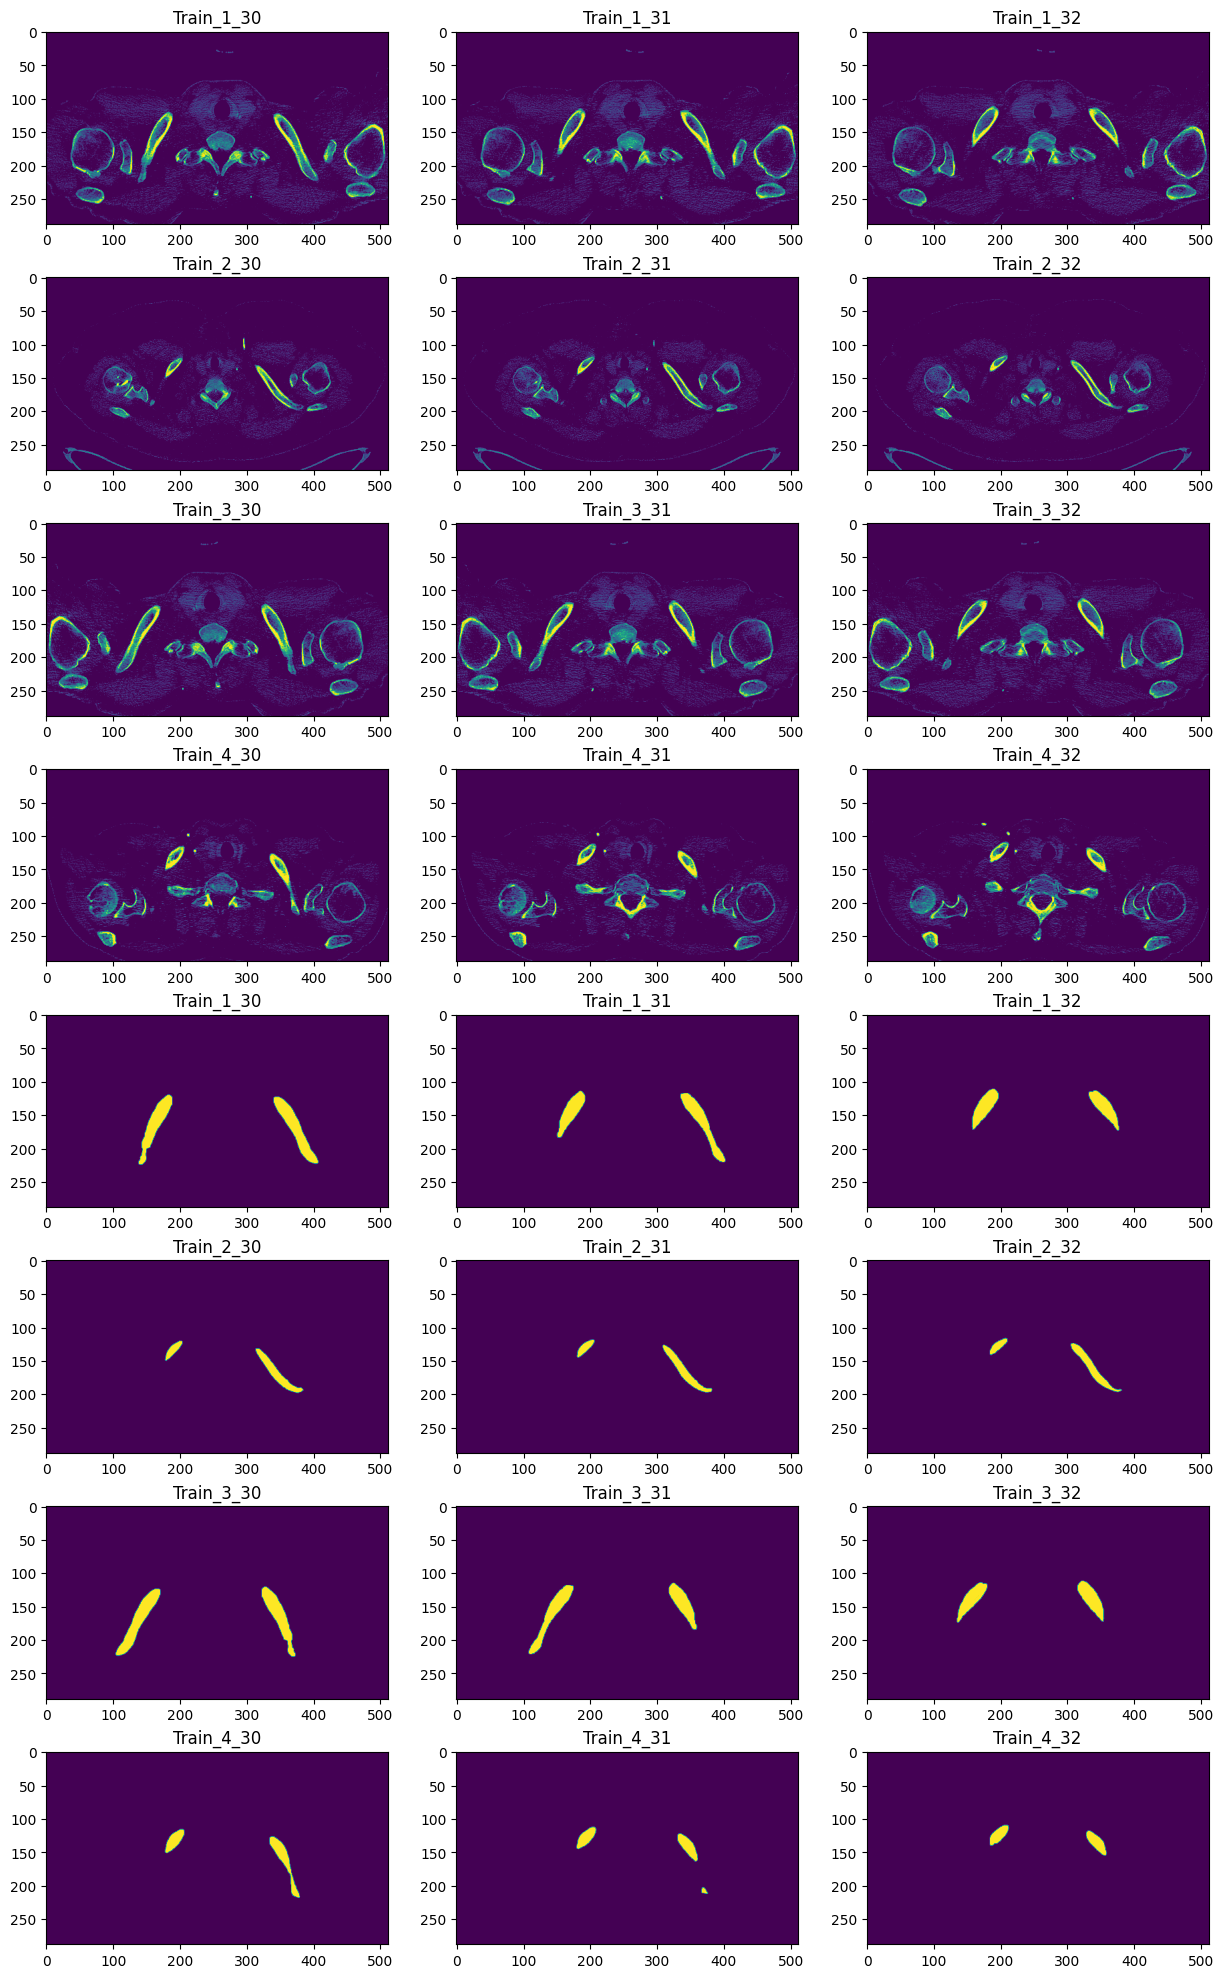

In [2]:
#load data
x_train, y_train, x_val, y_val, x_test, y_test = create_train_val_test(dir_Data_Train)

#visualize
num_plot = 1
fig = plt.figure(figsize=(15,25))
for i in range(x_train.shape[0]):
    if i==4:break
    for j in range(3):
        ax_x = fig.add_subplot(8, 3, num_plot)
        ax_x.imshow(x_train[i][30+j])
        ax_x.set_title('Train_{}_{}'.format(i+1,30+j))
        ax_y = fig.add_subplot(8, 3, num_plot+12)
        ax_y.imshow(y_train[i][30+j])
        ax_y.set_title('Train_{}_{}'.format(i+1,30+j))
        num_plot+=1
plt.show()

#additional_process for 2d U-net
x_train, y_train, x_val, y_val, x_test, y_test = additional_process(x_train, y_train, x_val, y_val, x_test, y_test)

#save datasets as .npy
for i in range(len(x_train)):
    np.save(os.path.join(dir_CT_2D_dataset+"/train", 'label_%03d.npy' % i), y_train[i])
    np.save(os.path.join(dir_CT_2D_dataset+"/train", 'input_%03d.npy' % i), x_train[i])

for i in range(len(x_test)):
    np.save(os.path.join(dir_CT_2D_dataset+"/test", 'label_%03d.npy' % i), y_test[i])
    np.save(os.path.join(dir_CT_2D_dataset+"/test", 'input_%03d.npy' % i), x_test[i])

for i in range(len(x_val)):
    np.save(os.path.join(dir_CT_2D_dataset+"/val", 'label_%03d.npy' % i), y_val[i])
    np.save(os.path.join(dir_CT_2D_dataset+"/val", 'input_%03d.npy' % i), x_val[i])

# Training

In [4]:
start = time.time()

#Transform & DataLoader for train
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
dataset_train = Dataset(data_dir=os.path.join(dir_CT_2D_dataset, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=BATCH, shuffle=True, num_workers=0)
dataset_val = Dataset(data_dir=os.path.join(dir_CT_2D_dataset, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=BATCH, shuffle=True, num_workers=0)

#create network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet_2D().to(device)

#loss function
fn_tmp=FocalTverskyLoss().to(device)

#Optimizer
optim = torch.optim.Adam(net.parameters(), lr=LR)

#other
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)
num_batch_train = np.ceil(num_data_train / BATCH)
num_batch_val = np.ceil(num_data_val / BATCH)
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

#train
st_epoch = 0
net, optim, st_epoch = model_load(ckpt_dir=ckpt_dir, net=net, optim=optim) 

total_train_loss_arr = []
total_val_loss_arr = []

for epoch in range(st_epoch + 1, EPOCH + 1):
        #train
        net.train()
        loss_arr = []
        for batch, data in enumerate(loader_train, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)
            output = net(input)
            # backward pass
            optim.zero_grad()
            loss=fn_tmp.forward(output,label)
            loss.backward()
            optim.step()
            # data process
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))
            #print
            loss_arr += [loss.item()]
            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, EPOCH, batch, num_batch_train, np.mean(loss_arr)))
        total_train_loss_arr += [np.mean(loss_arr)]

        #validation
        with torch.no_grad():
            net.eval()
            loss_arr = []

            for batch, data in enumerate(loader_val, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)
                output = net(input)
                # backward pass
                loss=fn_tmp.forward(output,label)
                # data process
                label = fn_tonumpy(label)
                input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                output = fn_tonumpy(fn_class(output))
                #print
                loss_arr += [loss.item()]
                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                      (epoch, EPOCH, batch, num_batch_val, np.mean(loss_arr)))
        total_val_loss_arr += [np.mean(loss_arr)]

        # save model & history every 20 epochs 
        if epoch % 20 == 0:
            model_save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)
            np.save(history_dir+"/train_loss_{}".format(epoch), total_train_loss_arr)
            np.save(history_dir+"/val_loss_{}".format(epoch), total_val_loss_arr)

print(f"{time.time()-start:.4f} sec")

2.9711 sec


# Test

In [6]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
dataset_test = Dataset(data_dir=os.path.join(dir_CT_2D_dataset, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=BATCH, shuffle=False, num_workers=0)
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / BATCH)
test_result_dir = os.path.join(dir_CT_2D_dataset, 'test_result')
if not os.path.exists(test_result_dir):
    os.makedirs(os.path.join(test_result_dir, 'png'))
    os.makedirs(os.path.join(test_result_dir, 'numpy'))
net, optim, st_epoch = model_load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
      net.eval()
      loss_arr = []
      for batch, data in enumerate(loader_test, start=1):
          label = data['label'].to(device)
          input = data['input'].to(device)
          output = net(input)
          loss=fn_tmp.forward(output,label)
          loss_arr += [loss.item()]
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
          output = fn_tonumpy(fn_class(output))
          id =batch 
          plt.imsave(os.path.join(test_result_dir, 'png', 'label_%04d.png' % id), label.squeeze(), cmap='gray')
          plt.imsave(os.path.join(test_result_dir, 'png', 'input_%04d.png' % id), input.squeeze(), cmap='gray')
          plt.imsave(os.path.join(test_result_dir, 'png', 'output_%04d.png' % id), output.squeeze(), cmap='gray')
          np.save(os.path.join(test_result_dir, 'numpy', 'label_%04d.npy' % id), label.squeeze())
          np.save(os.path.join(test_result_dir, 'numpy', 'input_%04d.npy' % id), input.squeeze())
          np.save(os.path.join(test_result_dir, 'numpy', 'output_%04d.npy' % id), output.squeeze())
print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

AVERAGE TEST: BATCH 0209 / 0209 | LOSS 0.1085


# Result


<Average>
Manual=> Precision: 0.965 Recall: 0.880 IoU: 0.852 DICE: 0.902
Sklearn=> Precision: 0.965 Recall: 0.880 F1:0.902
Confusion Matrix :
[[  228800    47626]
 [    7798 30670848]]


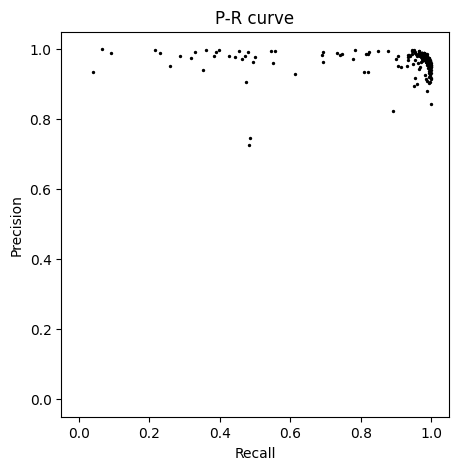

In [7]:
test_result_dir = dir_CT_2D_dataset_test
channel_of_test_patients = 1
lst_batch_dic_result = []

plt.figure(figsize=(5,5))
for nBatch in range(channel_of_test_patients):

    lst_data_png = os.listdir(test_result_dir+'/png')

    lst_label_png = [f for f in lst_data_png if f.startswith('label')]
    lst_output_png = [f for f in lst_data_png if f.startswith('output')]

    lst_label_png.sort()
    lst_output_png.sort()

    sum_iou=[]

    dic_result = {  'sum_manual_iou': [],
                    'sum_manual_dice': [],
                    'sum_manual_precision': [],
                    'sum_manual_recall': [],
                    'x_recall': [],
                    'x_precision': [],
                    'sum_skl_precision': [],
                    'sum_skl_recall': [],
                    'sum_skl_f1score': [],
                    'sum_tp': 0,
                    'sum_fn': 0,
                    'sum_fp': 0,
                    'sum_tn': 0   }

    for i in range(len(lst_label_png)):

        grd_truth = cv2.imread(test_result_dir + '/png/{}'.format(lst_label_png[i]))
        grd_truth_gray = cv2.cvtColor(grd_truth, cv2.COLOR_BGR2GRAY)
        res, grd_truth_thr = cv2.threshold(grd_truth_gray, 127.5, 255, cv2.THRESH_BINARY)

        masked = cv2.imread(test_result_dir + '/png/{}'.format(lst_output_png[i]))
        masked_gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
        res, masked_thr = cv2.threshold(masked_gray, 127.5, 255, cv2.THRESH_BINARY)

        intersection = cv2.countNonZero(cv2.bitwise_and(grd_truth_thr, masked_thr))
        union = cv2.countNonZero(cv2.bitwise_or(grd_truth_thr,masked_thr))

        #manual
        tp = cv2.bitwise_and(grd_truth_thr, masked_thr)
        fn = grd_truth_thr - tp
        fp = masked_thr - tp
        tn = np.invert(cv2.bitwise_or(grd_truth_thr,masked_thr)) +2

        tp_count = cv2.countNonZero(cv2.bitwise_and(grd_truth_thr, masked_thr))
        fn_count = cv2.countNonZero(grd_truth_thr - tp)
        fp_count = cv2.countNonZero(masked_thr - tp)
        tn_count = cv2.countNonZero(np.invert(cv2.bitwise_or(grd_truth_thr,masked_thr)) +2)

        #zero 
        if np.sum(intersection)==0:
            continue

        iou_test = tp_count /(tp_count+fp_count+fn_count)
        dice_test = 2*tp_count / ((tp_count + fn_count) + (tp_count + fp_count))
        precision_test = tp_count / (tp_count + fp_count) 
        recall_test = tp_count / (tp_count + fn_count)

        dic_result['sum_manual_iou'].append(iou_test)
        dic_result['sum_manual_dice'].append(dice_test)
        dic_result['sum_manual_precision'].append(precision_test)
        dic_result['sum_manual_recall'].append(recall_test)
        dic_result['x_recall'].append(i)
        dic_result['x_precision'].append(i)

        #sklearn
        y_true = grd_truth_thr
        y_pred = masked_thr
        dic_result['sum_skl_precision'].append(precision_score(y_true,y_pred, average='micro'))
        dic_result['sum_skl_recall'].append(recall_score(y_true, y_pred, average='micro'))
        dic_result['sum_skl_f1score'].append(f1_score(y_true,y_pred, average='micro'))

        dic_result['sum_tp'] += tp_count
        dic_result['sum_fn'] += fn_count
        dic_result['sum_fp'] += fp_count
        dic_result['sum_tn'] += tn_count

    lst_batch_dic_result.append(dic_result)

    #result
    result_iou = np.sum(dic_result['sum_manual_iou']) / len(dic_result['sum_manual_iou'])
    result_dice = np.sum(dic_result['sum_manual_dice']) / len(dic_result['sum_manual_dice'])
    result_precision = np.sum(dic_result['sum_manual_precision']) / len(dic_result['sum_manual_precision'])
    result_recall = np.sum(dic_result['sum_manual_recall']) / len(dic_result['sum_manual_recall'])
    result_skl_precision = np.sum(dic_result['sum_skl_precision']) / len(dic_result['sum_skl_precision'])
    result_skl_recall = np.sum(dic_result['sum_skl_recall']) / len(dic_result['sum_skl_recall'])
    result_skl_f1score = np.sum(dic_result['sum_skl_f1score']) / len(dic_result['sum_skl_f1score'])

    print()
    print('<Average>')
    print('Manual=>','Precision: %.3f' % result_precision,'Recall: %.3f' % result_recall,'IoU: %.3f' % result_iou,'DICE: %.3f' % result_dice)
    print('Sklearn=>',"Precision: %.3f" % result_skl_precision, "Recall: %.3f" % result_skl_recall, "F1:%.3f" % result_skl_f1score)
    print('Confusion Matrix :')
    print(np.array([[dic_result['sum_tp'], dic_result['sum_fn']],[dic_result['sum_fp'], dic_result['sum_tn']]]))

    plt.title('P-R curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05]) 
    plt.scatter(dic_result['sum_manual_recall'], dic_result['sum_manual_precision'], s=2, color ='black')
plt.show()

np_test_inx = np.load(dir_CT_2D_dataset+'/index/test_inx.npy')
total_len = []
for num_test_patient in range(4):
    test_i = [i for i in range(len(np_test_inx)) if np_test_inx[i]>=96*(num_test_patient) and np_test_inx[i]<96*(num_test_patient+1) ]
    test_len = 96-len(np_test_inx[test_i])
    total_len.append(test_len)

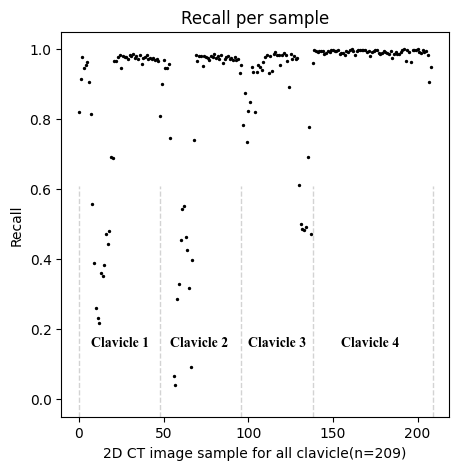

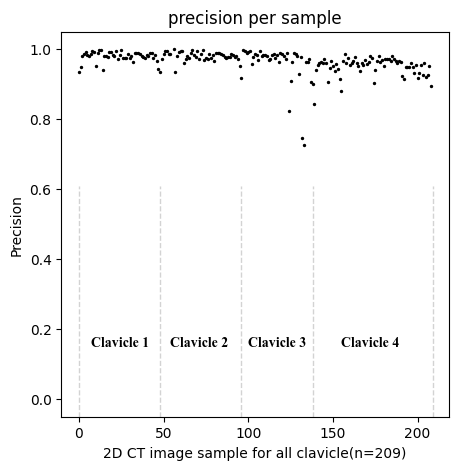

In [8]:
font2 = {'family': 'Times New Roman',
      'color':  'black',
      'weight': 'bold',
      'size': 10,
      'alpha': 1.0}

plt.figure(figsize=(5,5))
plt.title('Recall per sample')
plt.xlabel('2D CT image sample for all clavicle(n=209)')
plt.ylabel('Recall')
plt.ylim([-0.05,1.05])
plt.scatter(x=lst_batch_dic_result[0]['x_recall']  ,   y=lst_batch_dic_result[0]['sum_manual_recall'], s=2, color ='black')
plt.text(7, 0.15, 'Clavicle 1', fontdict=font2)
plt.text(54, 0.15, 'Clavicle 2', fontdict=font2)
plt.text(100, 0.15, 'Clavicle 3', fontdict=font2)
plt.text(155, 0.15, 'Clavicle 4', fontdict=font2)
plt.axvline(0, 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0]+total_len[1], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0]+total_len[1]+total_len[2], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0]+total_len[1]+total_len[2]+total_len[3], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.show()

plt.figure(figsize=(5,5))
plt.title('precision per sample')
plt.xlabel('2D CT image sample for all clavicle(n=209)')
plt.ylabel('Precision')
plt.ylim([-0.05,1.05])
plt.scatter(x=lst_batch_dic_result[0]['x_precision']  ,y=lst_batch_dic_result[0]['sum_manual_precision'], s=2, color ='black')
plt.text(7, 0.15, 'Clavicle 1', fontdict=font2)
plt.text(54, 0.15, 'Clavicle 2', fontdict=font2)
plt.text(100, 0.15, 'Clavicle 3', fontdict=font2)
plt.text(155, 0.15, 'Clavicle 4', fontdict=font2)
plt.axvline(0, 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0]+total_len[1], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0]+total_len[1]+total_len[2], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0]+total_len[1]+total_len[2]+total_len[3], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.show()


if len(lst_batch_dic_result[0]['x_precision']) == np.sum(total_len):
    for i in range(len(total_len)):
        plt.figure(figsize=(5,5))
        plt.title('Clavicle {} : P-R Accuracy per sample'.format(i+1))
        plt.xlabel('2D CT image sample(n={})'.format(total_len[i]))
        plt.ylabel('P-R Accuracy')
        plt.ylim([-0.05,1.05])
        plt.scatter(x=list(range(0,total_len[i]))  ,y=lst_batch_dic_result[0]['sum_manual_recall'][int(np.sum(total_len[:i])) : int(np.sum(total_len[:i+1])) ], s=2, color='red', label='Recall')
        plt.scatter(x=list(range(0,total_len[i]))  ,y=lst_batch_dic_result[0]['sum_manual_precision'][int(np.sum(total_len[:i])) : int(np.sum(total_len[:i+1])) ], s=2, color='blue', label='Precision')
        plt.legend()
        plt.show()

In [12]:
print('Precision with minimum:', np.min(lst_batch_dic_result[0]['sum_manual_precision']))
print('Recall with minimum:', np.min(lst_batch_dic_result[0]['sum_manual_recall']))


Precision with minimum: 0.7269681742043551
Recall with minimum: 0.04033149171270718
